In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 

from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor

# EDA Summary
1. Data shape: The training set consists of 31285 rows and 15 columns
2. Data types: 10 columns contains float64 data type and 5 has int data type.
3. Target: the target name is visibility.
4. Feature Analysis:
    . Independent Variable:
        . There is not missing value in table.
        . Also there is no discrete numerical value in the table.
        . All the independant features are skewed. Hence they deviate from the normal distribution.The majority of them show negative skewness. Based on that one should consider of using the algorithms which do not require normal distribution such as decision tree and XGBoost...
        . sealevelpressure, precip, stationpressure, windspeed features contain outliers. Outliers can affect our models and it can also be a valuable source of information, providing us insights about specific behaviours. 
        
    . Univariable analyis: visibilty shows 'peakedness', negative skewness and does not follow the diagonal line of normal probability plot. It has heigh value of kurtosis which means that visibility also contains outliers
    . Multivariate analysis: we have multicollinarity problem. Many feature are strongly correllated.This may affect our model accuracy. However,we must do futher invastigation before droping any feature. Because is hard to say what threshold to use. We will also use feacture selection approach.

In [2]:
df = pd.read_csv('../Training_set_From_Db/training_set.csv')

In [3]:
df.head()

,visibility,drybulbtempf,wetbulbtempf,dewpointtempf,relativehumidity,windspeed,winddirection,stationpressure,sealevelpressure,precip,year,month,day,dayofmonth,dayofweek
0,6.0,33.0,32.0,31.0,92.0,0.0,0.0,29.97,29.99,0.01,2010,1,1,1,4
1,6.0,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99,0.02,2010,1,1,1,4
2,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99,0.02,2010,1,1,1,4
3,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.95,29.97,0.02,2010,1,1,1,4
4,5.0,33.0,32.0,31.0,92.0,0.0,0.0,29.93,29.96,0.02,2010,1,1,1,4


In [4]:
df_1 = df.copy()

In [5]:
df_1.shape

(31285, 15)

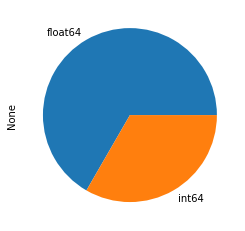

In [6]:
df_1.dtypes.value_counts().plot.pie();

In [7]:
# feature analysis: We will be focusing on original feature.Hence, the features added to the table during data transformation step will not included.
# missing data
df_1 = df_1.drop(['year', 'month', 'dayofweek', 'day', 'dayofmonth' ], axis=1)
df_1.isna().sum()

visibility          0
drybulbtempf        0
wetbulbtempf        0
dewpointtempf       0
relativehumidity    0
windspeed           0
winddirection       0
stationpressure     0
sealevelpressure    0
precip              0
dtype: int64

In [8]:
# discrete numerical value
discrete_features = [feature for feature in df_1.columns if df_1[feature].nunique() < 15]
discrete_features

[]

In [9]:
def hist (feature, attr=None):
    sns.distplot(feature,bins=5)
    plt.title(attr)

In [10]:
def proba (feature, attr=None):
    stats.probplot(feature, plot=plt)
    plt.title(attr)
    plt.title(attr)

In [11]:
def boxplot (feature, attr=None):
    sns.boxplot(feature)
    plt.title(attr)

In [12]:
#As we have only continous numerical feature, let's see their distribution. 
def plot (data, row_no, column_no, plot_type, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    i=0
    for feature in data:
        i += 1
        plt.subplot(row_no, column_no, i)
        plot_type(data[feature], feature)
    plt.show()

/Users/vipuldani/.conda/envs/visibility_project/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


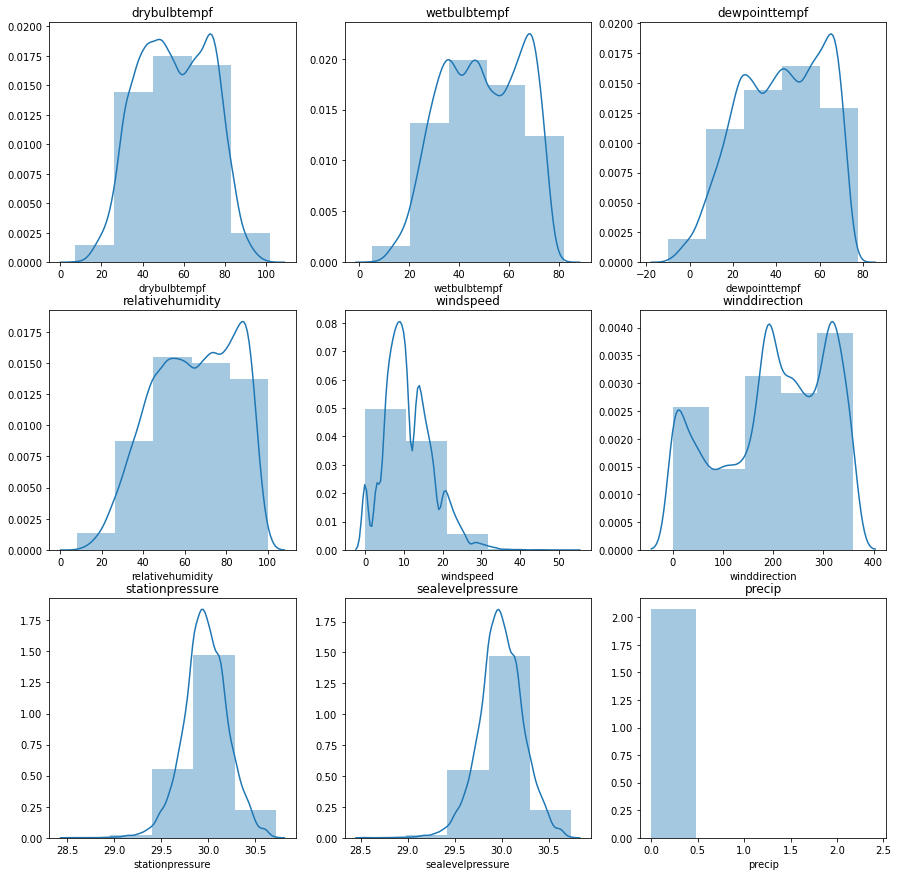

In [13]:
data = df_1.drop('visibility', axis=1)
plot(data, 3, 3, hist)

**Insights**:
The features are skewed. 

In [14]:
 for feature in data:
        print(f'{feature :-<30} skewed: {np.round(df_1[feature].skew(), 4)} | kurtosis:  {np.round(df_1[feature].kurt(), 4)}')

drybulbtempf------------------ skewed: -0.0213 | kurtosis:  -0.9029
wetbulbtempf------------------ skewed: -0.1235 | kurtosis:  -1.0392
dewpointtempf----------------- skewed: -0.246 | kurtosis:  -0.9346
relativehumidity-------------- skewed: -0.2402 | kurtosis:  -0.9198
windspeed--------------------- skewed: 0.7041 | kurtosis:  0.9536
winddirection----------------- skewed: -0.3849 | kurtosis:  -0.9884
stationpressure--------------- skewed: -0.2323 | kurtosis:  0.9325
sealevelpressure-------------- skewed: -0.2305 | kurtosis:  0.91
precip------------------------ skewed: 21.976 | kurtosis:  819.6564


**Insights**:
The majority of features show negative skewness.
Feature called precip has heigh value of kurtosis that means this feature contains a lot of outlier. However, the features have negative value kurtosis do not contain any outlier. We will use boxplot later to visualize the outliers of different features. 

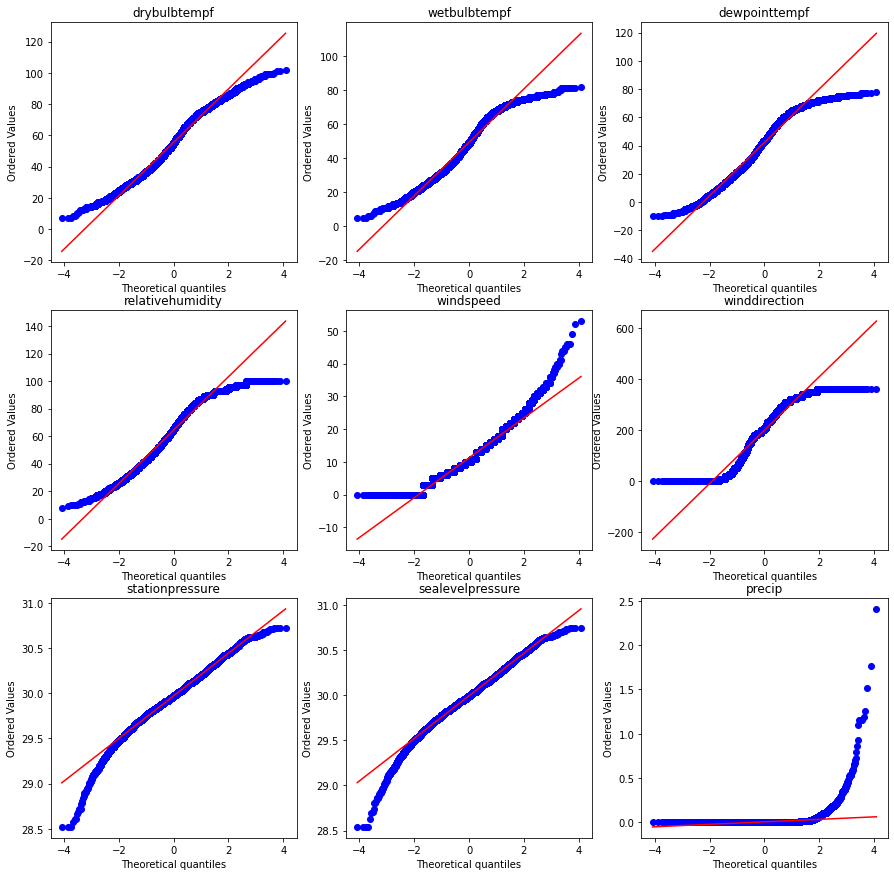

In [15]:
plot(data, 3, 3, proba)

**Insights**:
Above plots confirm what was mentioned earlier. The feature are skewed they do not follow the diagonal line of normal probability plot.

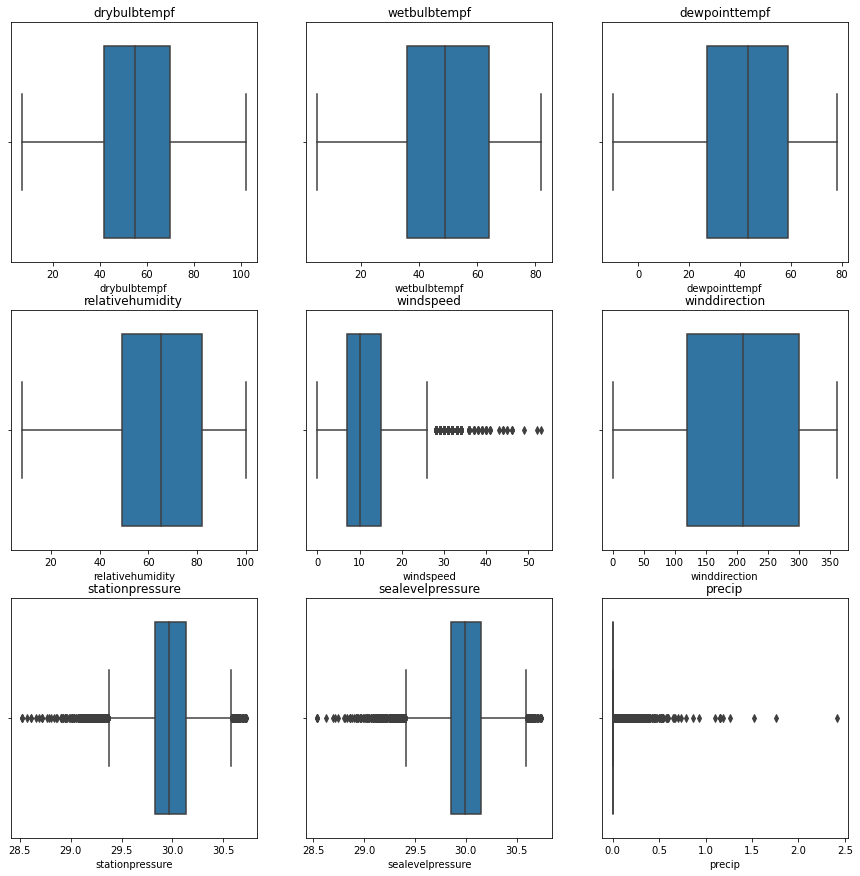

In [16]:
plot(data, 3, 3, boxplot)

**Insights**:
sealevelpressure, precip, stationpressure, windspeed show the presence of outliers. It is important to underline that those outliers must handle during data preprocessing.

In [17]:
#Univariable analyis
def plotTarget (figsize=(15, 5)):

  plt.figure(figsize=figsize)
  i = 0
  for item in (1, 2):
    i +=1
    plt.subplot(1, 2, i)
    if i == 1: sns.distplot(df_1['visibility'], bins=50, fit=stats.norm)
    else:  stats.probplot(df_1['visibility'], plot=plt)
    
  plt.show()

/Users/vipuldani/.conda/envs/visibility_project/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


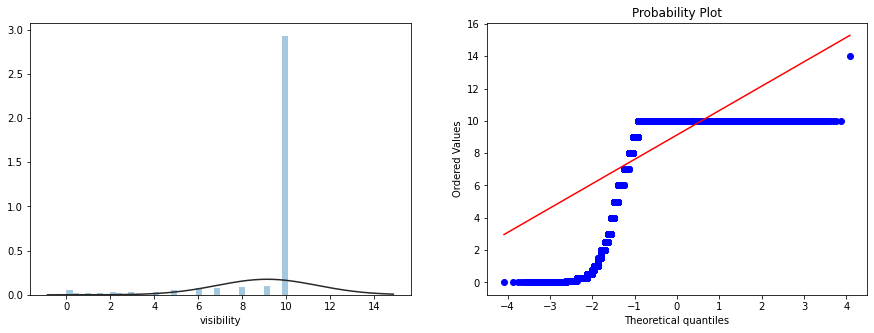

In [18]:
plotTarget()

In [19]:
'skewed: {} | kurtosis:  {}'.format(np.round(df_1['visibility'].skew(), 4), np.round(df_1['visibility'].kurt(), 4))

'skewed: -2.7797 | kurtosis:  6.7452'

**Insights**:
visibility shows negative skewness, does not follow the diagonal line of normal probability plot. It has heigh value of kurtosis which means that visibility also contains outliers

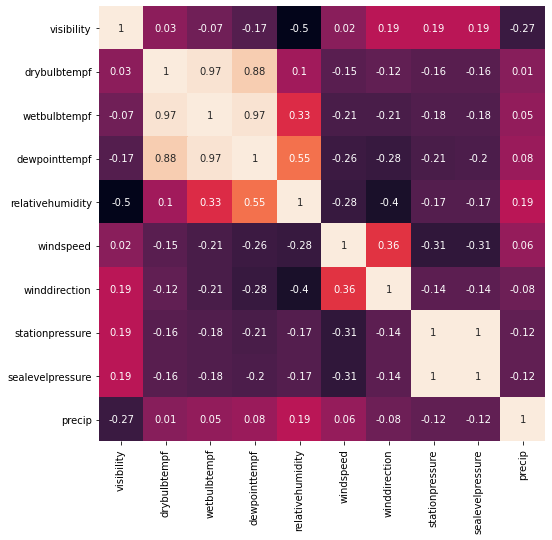

In [20]:
# Multivariate analysis
corr = np.round(df_1.corr(), 2)
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cbar=False)

**Insights**: We have multicollinarity. Multiple features are strongly correllated. However, we will keep all the feature for this moment, since it is quiet hard to say intuitively what threshold to use. We will use Ordinary Least Squares approach plus formal procedure for feature selection to select our feature.

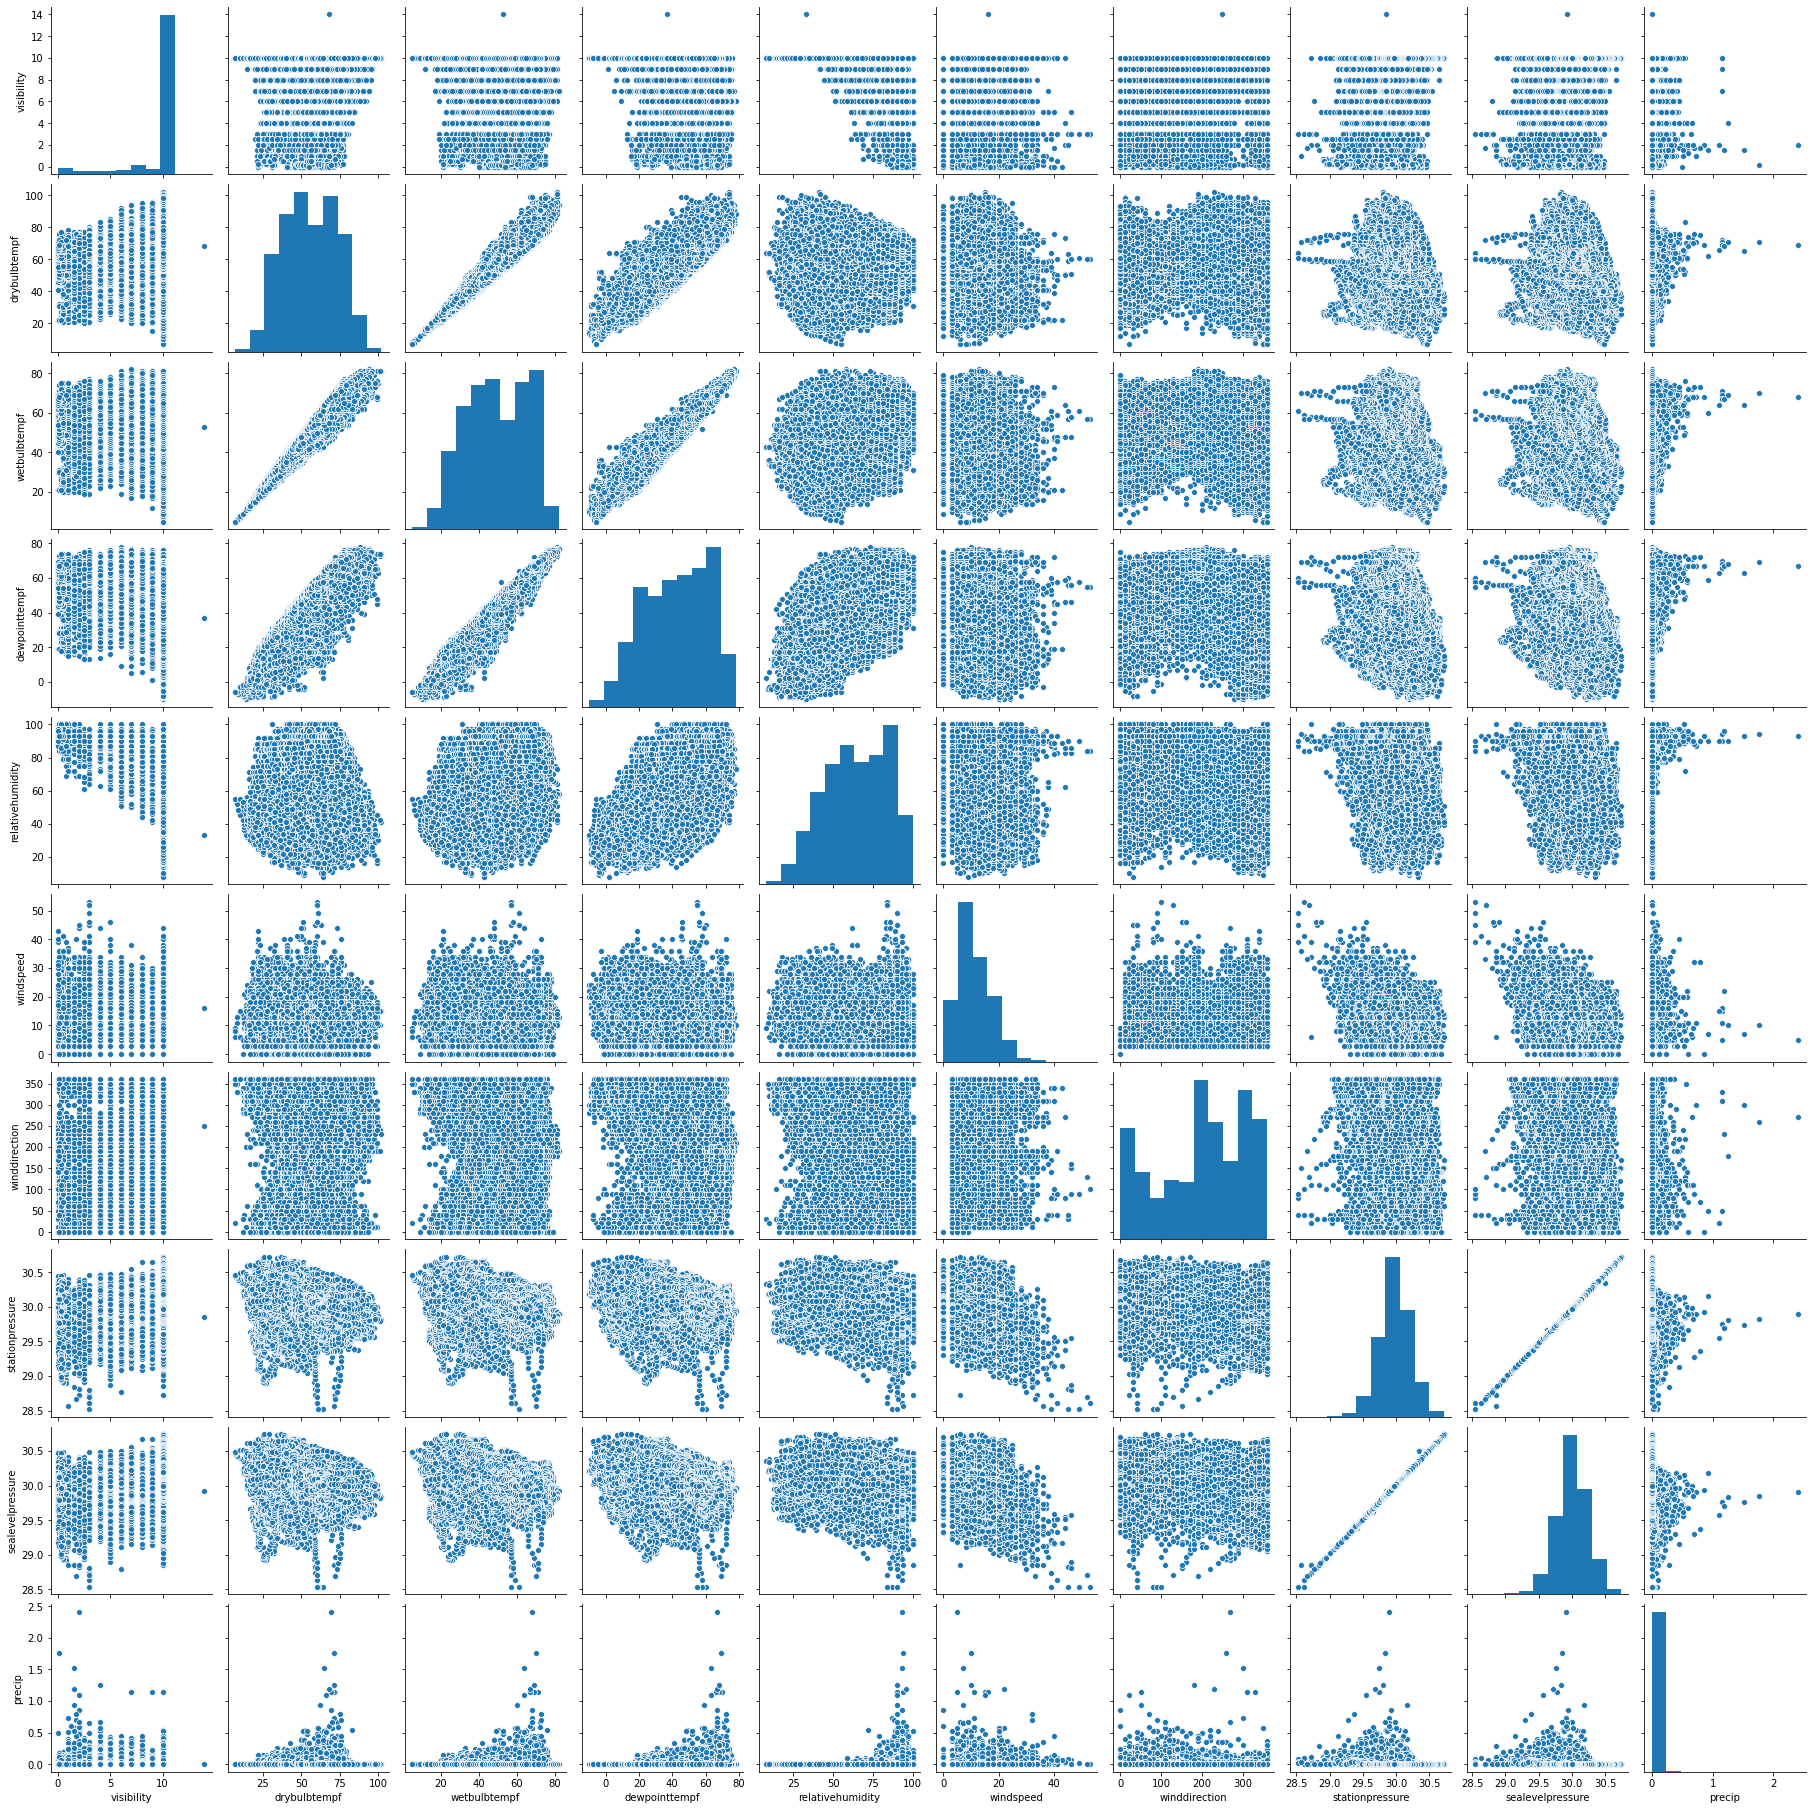

In [21]:
sns.pairplot(df_1);

**Insights**:
Although we already know some information about relationship between variable, this mega scatter plot gives us a reasonable idea about variables correllated.

# Feature selection

In [22]:
X = df.drop('visibility', axis=1)
y = df['visibility']

In [24]:
## Ordinary Least Squares
X_ols = sm.add_constant(X)

In [29]:
ols = sm.OLS(y, X_ols).fit()

In [30]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             visibility   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     1516.
Date:                Sat, 04 Jul 2020   Prob (F-statistic):               0.00
Time:                        00:34:10   Log-Likelihood:                -61925.
No. Observations:               31285   AIC:                         1.239e+05
Df Residuals:                   31270   BIC:                         1.240e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -84.3848     20.190     -4.180      0.000    -123.958     -44.812
drybulbtempf        -0.3812      0.008    -49.538      0.000      -0.396      -0.366
wetbulbtempf         0.0192      0.010      1.925      0.054      -0.000       0.039
dewpointtempf        0.4009      0.007     59.747      0.000       0.388       0.414
relativehumidity    -0.2418      0.003    -88.434      0.000      -0.247      -0.236
windspeed           -0.0253      0.002    -13.376      0.000      -0.029      -0.022
winddirection        0.0006      0.000      5.313      0.000       0.000       0.001
stationpressure      1.0309      2.369      0.435      0.663      -3.613       5.675
sealevelpressure    -0.4834      2.371     -0.204      0.838      -5.130       4.164
precip              -7.6897      0.256    -30.070      0.000      -8.191      -7.188
year                 0.0478      0.010      4.723      0.000       0.028       0.068
month               -0.0951      0.431     -0.221      0.825      -0.940       0.749
day                 -0.0073      0.014     -0.513      0.608      -0.035       0.021
dayofmonth           0.0041      0.014      0.290      0.772      -0.024       0.032
dayofweek            0.0129      0.005      2.591      0.010       0.003       0.023
==============================================================================
Omnibus:                     9107.151   Durbin-Watson:                   0.412
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33632.074
Skew:                          -1.431   Prob(JB):                         0.00
Kurtosis:                       7.197   Cond. No.                     4.14e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
kBest = SelectKBest(f_regression, k= 13)

In [32]:
kBest.fit(X, y)

SelectKBest(k=13, score_func=<function f_regression at 0x1a1a15de18>)

In [33]:
kBest_df = pd.DataFrame(kBest.scores_, columns=['scores'])

In [34]:
features_df = pd.DataFrame(X.columns, columns=['features'])

In [35]:
best_features = pd.concat([kBest_df, features_df], axis=1)
best_features.nlargest(13, 'scores')

,scores,features
3,10195.615619,relativehumidity
8,2537.933324,precip
7,1233.561404,sealevelpressure
6,1233.393783,stationpressure
5,1216.201500,winddirection
2,951.488844,dewpointtempf
1,166.292193,wetbulbtempf
13,82.954199,dayofweek
10,80.314320,month
12,70.079250,dayofmonth


In [36]:
rf = RandomForestRegressor(random_state=0)

In [37]:
rf.fit(X, y)

RandomForestRegressor(random_state=0)

In [38]:
f_importance_df = pd.Series(rf.feature_importances_, index=X.columns)

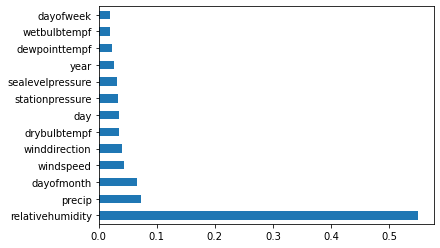

In [39]:
f_importance_df.nlargest(13).plot.barh();